# Copyright : fast.ai - Jeremy Howard & Sylvain Gugger - 2020 (GPLv3)

Cellules de code et plan du notebook adaptées du livre :

Deep Learning for Coders with fastai & PyTorch de Jeremy Howard et Sylvain Gugger.

The code in the original notebooks (and thus the code in this notebook) is covered by the GPL v3 license; see the LICENSE file for details.

In [1]:
from fastai2.vision.all import *

In [2]:
# Utilitaire
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

# Classification d'images

## De chats et chiens à la distinction fine des races d'animaux

[The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)
*Omkar M Parkhi and Andrea Vedaldi and Andrew Zisserman and C. V. Jawahar*

In [3]:
path = untar_data(URLs.PETS)

In [4]:
path.ls()

(#2) [Path('/storage/data/oxford-iiit-pet/images'),Path('/storage/data/oxford-iiit-pet/annotations')]

In [5]:
(path/"images").ls()

(#7393) [Path('/storage/data/oxford-iiit-pet/images/american_bulldog_146.jpg'),Path('/storage/data/oxford-iiit-pet/images/japanese_chin_12.jpg'),Path('/storage/data/oxford-iiit-pet/images/Sphynx_247.jpg'),Path('/storage/data/oxford-iiit-pet/images/beagle_158.jpg'),Path('/storage/data/oxford-iiit-pet/images/beagle_76.jpg'),Path('/storage/data/oxford-iiit-pet/images/shiba_inu_207.jpg'),Path('/storage/data/oxford-iiit-pet/images/Siamese_56.jpg'),Path('/storage/data/oxford-iiit-pet/images/keeshond_194.jpg'),Path('/storage/data/oxford-iiit-pet/images/miniature_pinscher_89.jpg'),Path('/storage/data/oxford-iiit-pet/images/leonberger_42.jpg')...]

In [6]:
filepath = (path/"images").ls()[0]
filepath.name

'american_bulldog_146.jpg'

In [7]:
re.findall(r'(.+)_\d+.jpg$', filepath.name)

['american_bulldog']

In [8]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [16]:
[tranform.name for tranform in aug_transforms(size=224, min_scale=0.75)]

['AffineCoordTfm', 'LightingTfm', 'RandomResizedCropGPU']

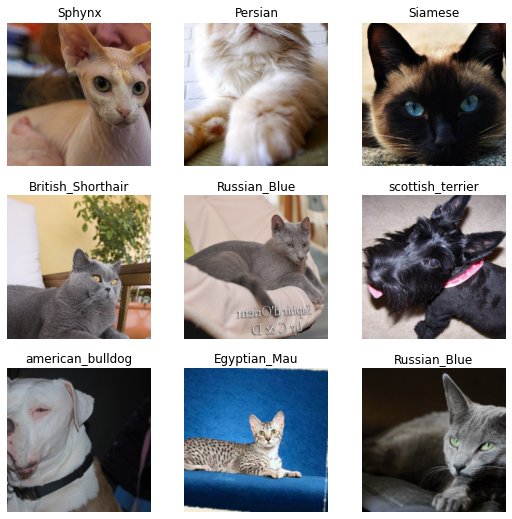

In [9]:
dls.show_batch()

## Data augmentation - Presizing

Création d'un batch de 100 images identiques

In [22]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([filepath]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()

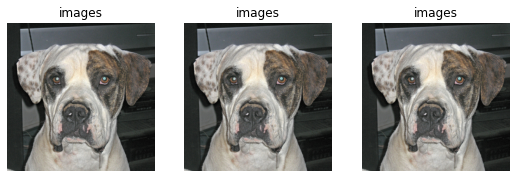

In [23]:
dls1.valid.show_batch(max_n=3)

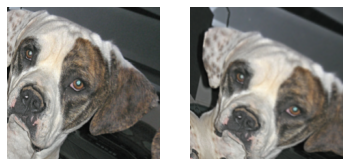

In [24]:
# Transformations réalisées les unes après les autres
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

# Transformations réalisées dans un pipeline sur le GPU
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), 
                       Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)

# Comparaison des résultats
_,axs = subplots(1, 2)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

## Tester et mettre au point un DataBlock

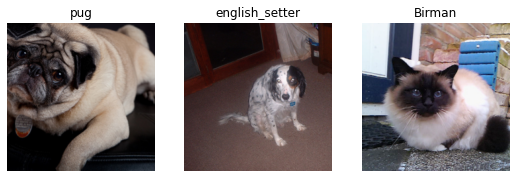

In [25]:
dls.show_batch(nrows=1, ncols=3)

In [24]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/oxford-iiit-pet/images/shiba_inu_98.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x374
  Pipeline: partial -> Categorize
    starting from
      /storage/data/oxford-iiit-pet/images/shiba_inu_98.jpg
    applying partial gives
      shiba_inu
    applying Categorize gives
      TensorCategory(33)

Final sample: (PILImage mode=RGB size=500x374, TensorCategory(33))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=500x374, TensorCategory(33))
    applying ToTensor gives
      (TensorImage of size 3x374x500, TensorC

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 374 and 375 in dimension 2 at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/TH/generic/THTensor.cpp:612

In [25]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.518096,0.315461,0.098782,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.481868,0.304137,0.095399,00:32
1,0.315691,0.245489,0.075778,00:32


## Cross entropy loss

### Viewing activations and labels

In [26]:
x,y = dls.one_batch()

In [27]:
y

TensorCategory([ 7, 22,  8, 26, 33,  4,  9, 33,  2, 30, 15, 31, 30, 24, 23,  6, 27, 25,
        26, 29, 36, 18,  7, 18, 32,  8, 36, 27, 16, 32, 15, 12, 11, 16, 30, 27,
        21, 36, 35,  3,  5,  4, 21, 27,  2,  5, 17,  7,  6,  9,  8,  3, 14,  6,
        26, 32, 11, 36, 13,  8, 30,  5, 15,  9], device='cuda:0')

In [28]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([4.3055e-08, 2.4208e-07, 1.1091e-04, 2.7725e-06, 1.8103e-05, 1.1021e-07,
        2.6488e-05, 9.9936e-01, 2.6258e-04, 1.9929e-08, 3.1683e-08, 1.4145e-06,
        3.7044e-07, 1.7925e-08, 8.2692e-08, 2.2305e-08, 9.7382e-07, 6.0412e-08,
        2.3996e-06, 3.2420e-08, 2.9778e-09, 4.0791e-07, 1.2788e-04, 2.1894e-05,
        2.3660e-07, 3.0511e-08, 1.5286e-08, 4.2196e-07, 3.8364e-06, 1.5445e-07,
        6.6241e-08, 5.5809e-05, 1.8949e-06, 1.9771e-08, 5.8426e-08, 1.6741e-06,
        3.1759e-07])

In [29]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

### Softmax

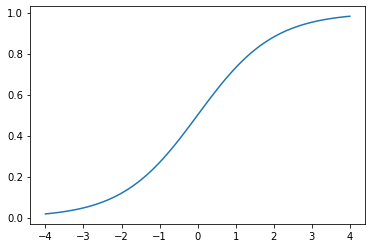

In [33]:
plot_function(torch.sigmoid, min=-4,max=4)

In [34]:
#hide
torch.random.manual_seed(42);

In [35]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [36]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [37]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [38]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log likelihood

In [39]:
targ = tensor([0,1,0,1,1,0])

In [40]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [41]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [42]:
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
df

,3,7,targ,idx,loss
0,0.602469,0.397531,0,0,0.602469
1,0.502065,0.497935,1,1,0.497935
2,0.133188,0.866811,0,2,0.133188
3,0.996640,0.003360,1,3,0.003360
4,0.595949,0.404051,1,4,0.404051
5,0.366118,0.633882,0,5,0.366118


In [43]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [44]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the `log`

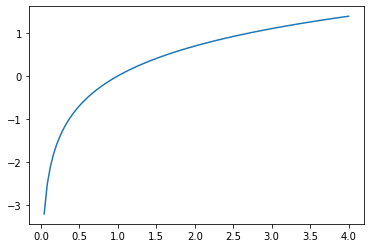

In [45]:
plot_function(torch.log, min=0,max=4)

In [46]:
loss_func = nn.CrossEntropyLoss()

In [47]:
loss_func(acts, targ)

tensor(1.8045)

In [48]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [49]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

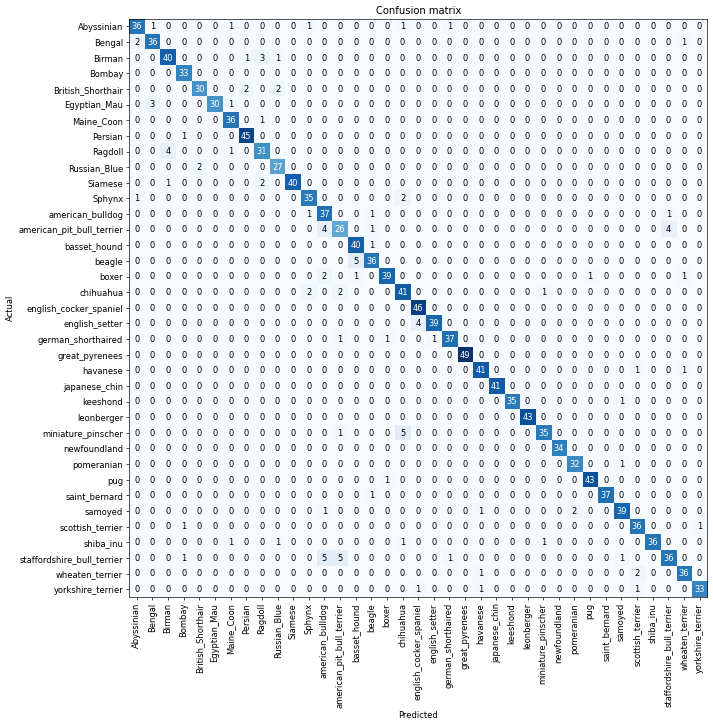

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [51]:
interp.most_confused(min_val=5)

[('beagle', 'basset_hound', 5),
 ('miniature_pinscher', 'chihuahua', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5)]

## Improving our model

### Learning rate finder

In [54]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.691894,5.252175,0.490528,00:25


epoch,train_loss,valid_loss,error_rate,time
0,4.221415,4.066999,0.776725,00:32
1,2.341416,1.367978,0.422192,00:31


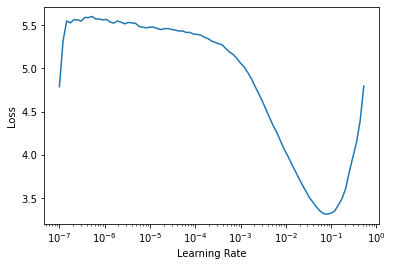

In [53]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [55]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 6.31e-03


In [56]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=6e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.063206,0.387836,0.110961,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.729967,0.646346,0.173207,00:31
1,0.406494,0.284538,0.088633,00:31


### Unfreezing and transfer learning

In [57]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.138528,0.339928,0.104195,00:25
1,0.517963,0.286641,0.087957,00:25
2,0.315610,0.246128,0.073748,00:25


In [58]:
learn.unfreeze()

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=7.585775847473997e-07)

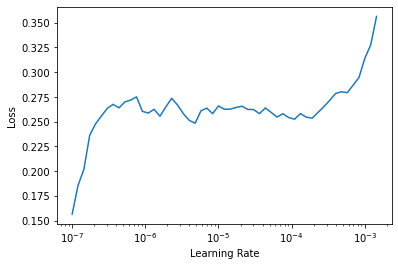

In [59]:
learn.lr_find()

In [60]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.258214,0.229297,0.071719,00:32
1,0.244831,0.225388,0.074425,00:32
2,0.225734,0.218312,0.067659,00:31
3,0.210456,0.214465,0.062923,00:32
4,0.194173,0.211718,0.062246,00:31
5,0.182622,0.213349,0.065629,00:31


### Discriminative learning rates

In [61]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.115057,0.337810,0.105548,00:26
1,0.539760,0.291335,0.092016,00:26
2,0.332870,0.237753,0.077131,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.267482,0.234121,0.073072,00:31
1,0.254349,0.229980,0.072395,00:31
2,0.229564,0.231214,0.073748,00:31
3,0.203906,0.224533,0.074425,00:31
4,0.189361,0.218713,0.069012,00:31
5,0.180013,0.213483,0.065629,00:31
6,0.159577,0.213275,0.064276,00:31
7,0.149588,0.208382,0.062923,00:31
8,0.140246,0.211009,0.065629,00:31
9,0.130604,0.209260,0.062246,00:31


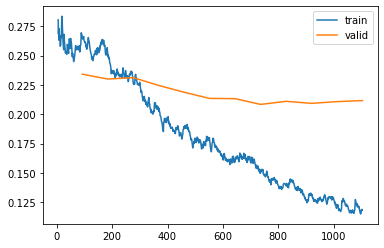

In [62]:
learn.recorder.plot_loss()

### Selecting the number of epochs

### Deeper architectures

In [63]:
#from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate) #.to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.273174,0.285852,0.089986,00:45
1,0.565775,0.264977,0.080514,00:43
2,0.432513,0.252678,0.081191,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.286545,0.242117,0.081867,01:05
1,0.303293,0.379559,0.108931,00:57
2,0.253836,0.267058,0.079161,00:57
3,0.158468,0.224737,0.063599,00:57
4,0.094714,0.225613,0.062246,00:57
5,0.054199,0.215326,0.059540,00:57
